In [1]:
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
import tqdm
from matplotlib.cm import get_cmap
import fbpca
import datetime

from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils

In [2]:
today = datetime.date.today()
figures = './figures/{}_{{}}'.format(today)
figures

'./figures/2021-06-02_{}'

# Read in data 
- meta
- data

# Output data
- meta (new x, y, columns)
- data
- rotation mat

In [3]:
input = '../data/processed_merfish_ad_mouse_june2_2021.hdf5'
samples = [
    'Xulab_2_5_region_0',
    'Xulab_2_5_region_1',
    'Xulab_2_6_region_0',
    'Xulab_2_6_region_1',
]

alldata = {}
metas = {}
datas = {}
for sample in samples:
    # one sample
    meta = pd.read_hdf(input, 'meta_'+sample)
    meta['sample'] = sample 
    
    data = pd.read_hdf(input, 'mat_'+sample)
    
    toplot = meta.join(data)
    
    metas[sample] = meta
    datas[sample] = data
    alldata[sample] = toplot
    

# Rotation 

In [4]:
# rotation transformation
def rotate(mat, vec_chiral):
    """(n,2) matrix as input
    """
    U, s, Vt = fbpca.pca(mat, k=2)
    coords = U.dot(np.diag(s))

    # det = -1 reflection; det = 1 rotation
    if np.linalg.det(Vt) < 0: # ~ -1
        coords[:,0] = -coords[:,0]
        Vt[0,:] = -Vt[0,:]
        
    delta = vec_chiral[coords[:,1]>0].sum() - vec_chiral[coords[:,1]<0].sum()
    if delta < 0: # rotate 180 
        coords = -coords
        Vt = -Vt
    return coords, Vt

In [5]:
all_Vts = {}
for sample in alldata.keys():
    toplot = alldata[sample]
    toplot[['x', 'y']], Vt = rotate(toplot[['center_x', 'center_y']].values, toplot['Slc17a7'].values)
    
    all_Vts[sample] = Vt
    metas[sample][['x', 'y']] = toplot[['x', 'y']]

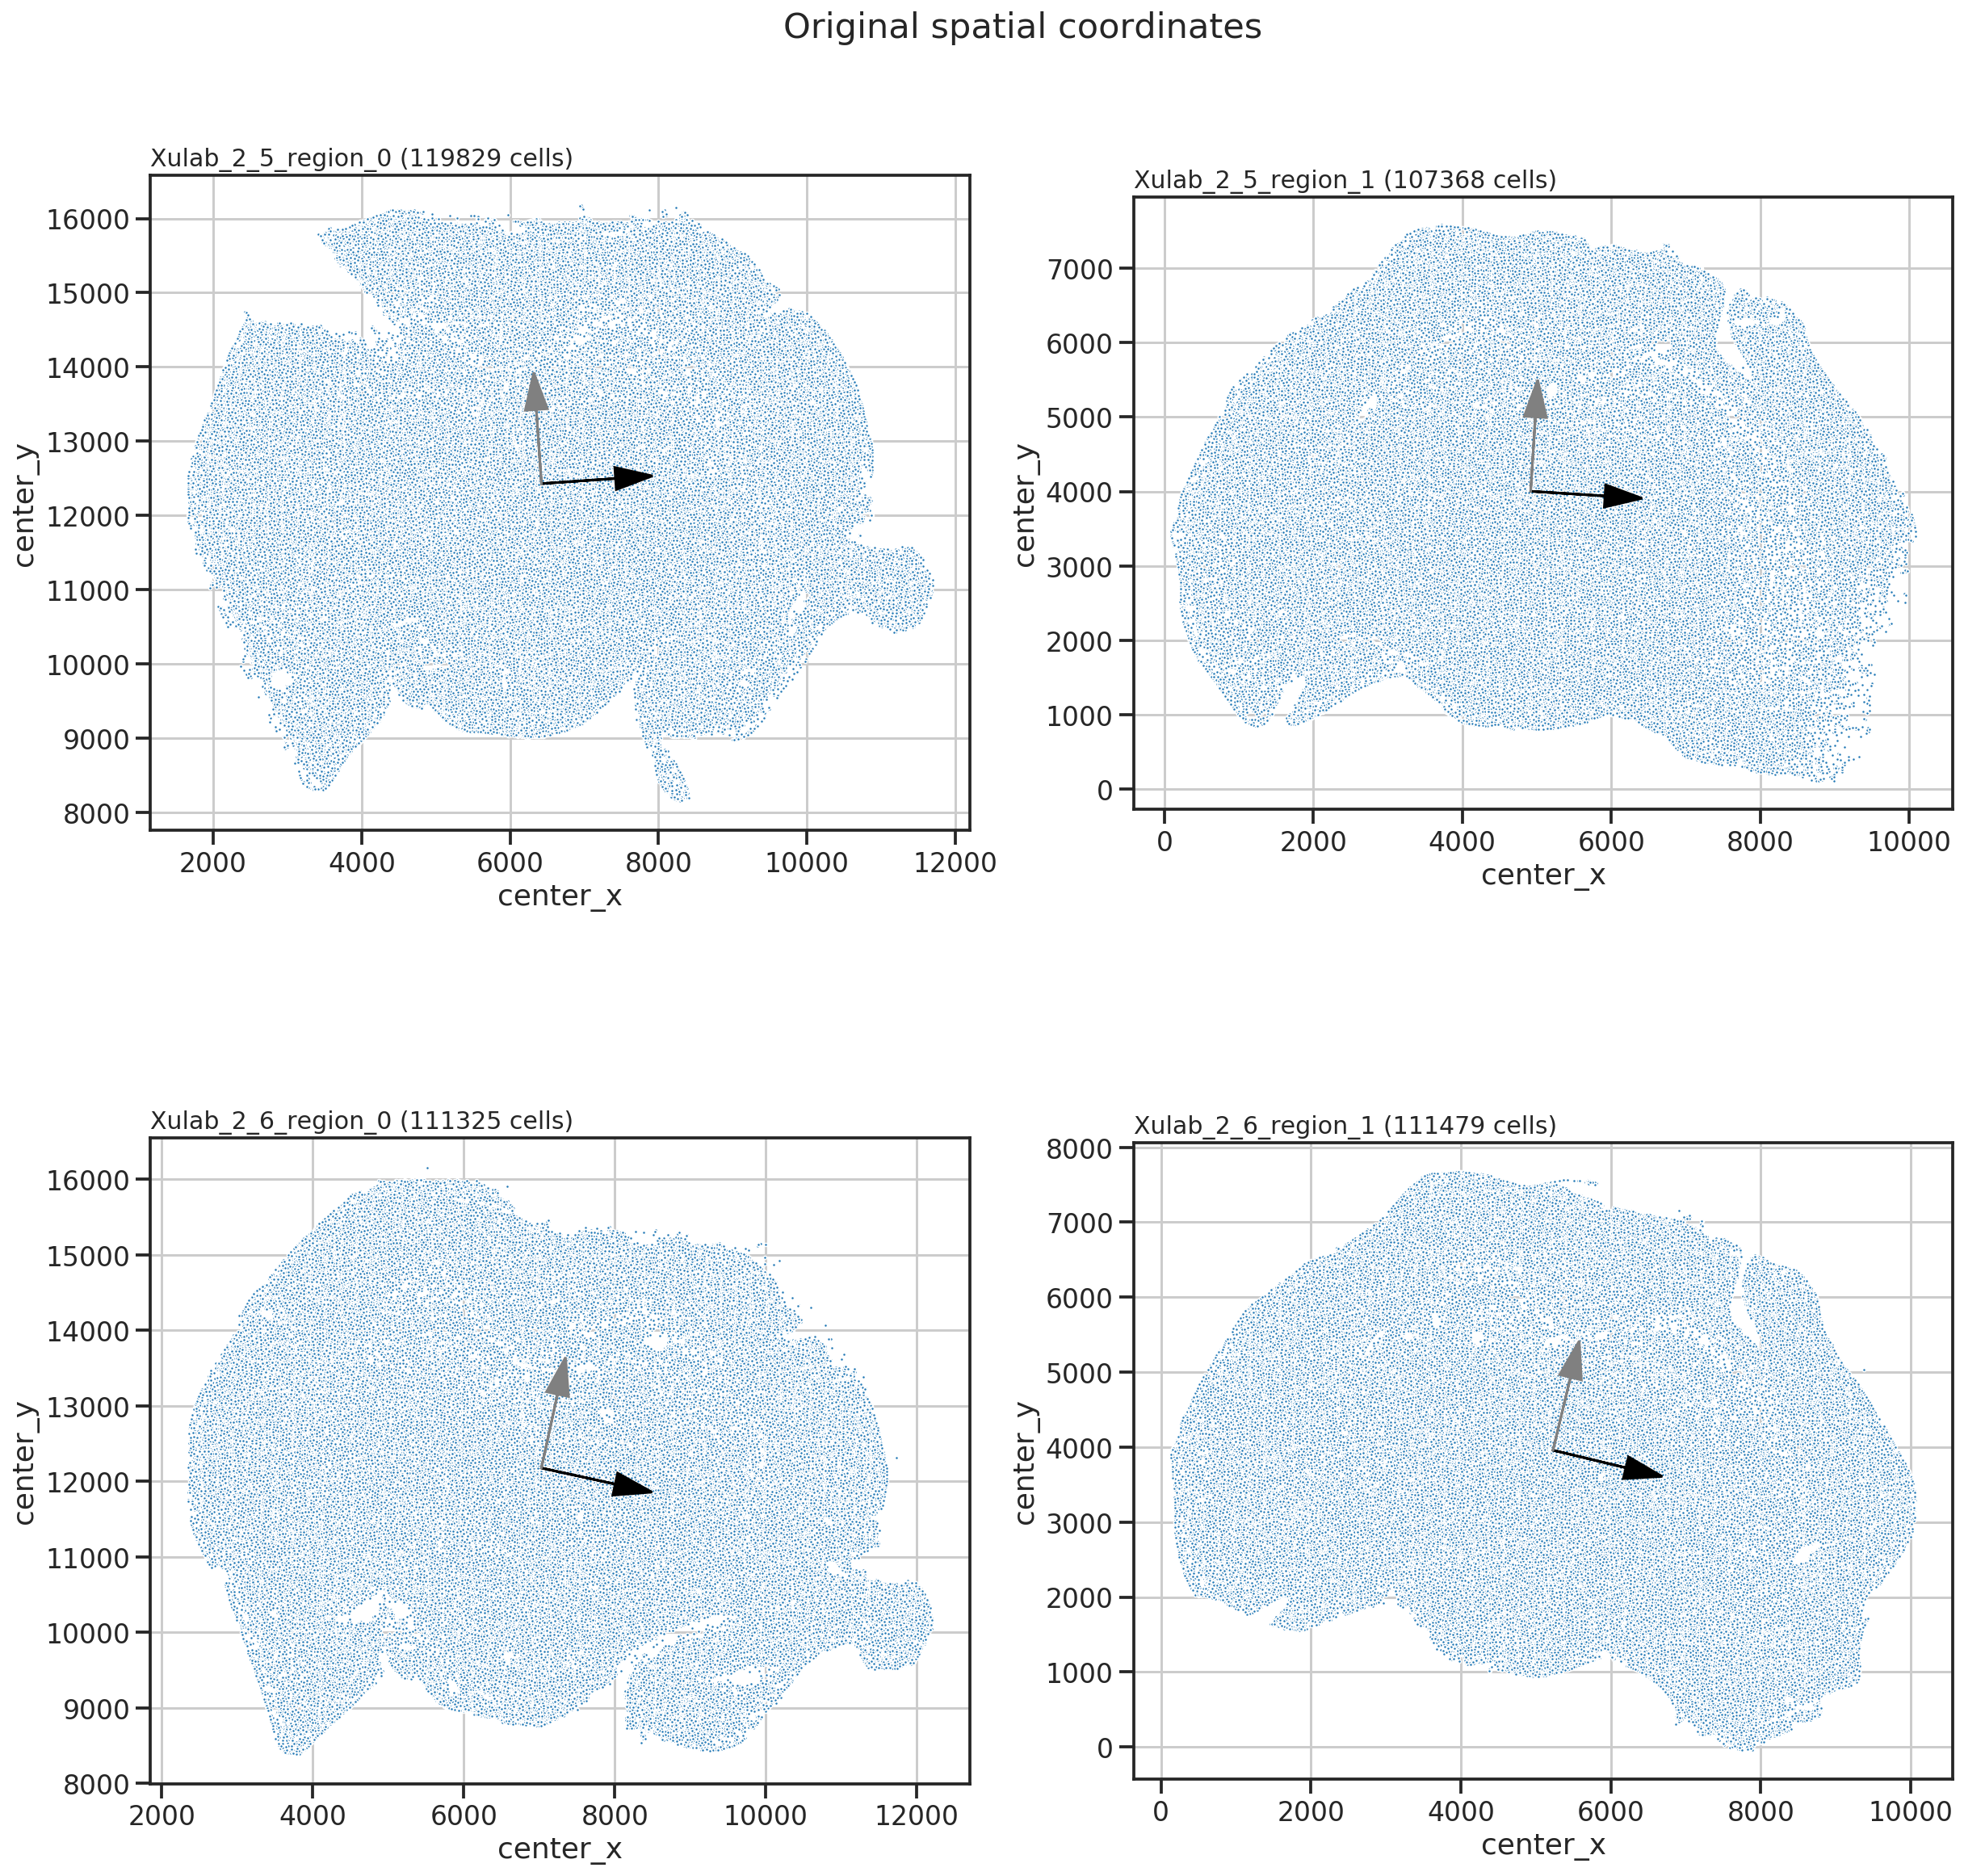

In [6]:
x, y, suptitle = 'center_x', 'center_y', 'Original spatial coordinates'
fig, axs = plt.subplots(2, 2, figsize=(20,20))
for i, (ax, sample) in enumerate(zip(axs.flat, alldata.keys())):
    toplot = alldata[sample]
    Vt = all_Vts[sample]
    
    sns.scatterplot(x=x, y=y, data=toplot, 
                    s=4, markers=dict(marker_edge_color='none'),
                    rasterized=True,
                    ax=ax,
                   )
    ax.set_aspect('equal')
    xmean, ymean = toplot[x].mean(), toplot[y].mean()
    scale = 1000
    ax.arrow(xmean, ymean, scale*Vt[0,0], scale*Vt[0,1], 
             head_width=0.3*scale, head_length=0.5*scale, fc='k', ec='k')
    ax.arrow(xmean, ymean, scale*Vt[1,0], scale*Vt[1,1], 
             head_width=0.3*scale, head_length=0.5*scale, fc='gray', ec='gray')
    ax.set_title("{} ({} cells)".format(sample, len(toplot)), loc='left', fontsize=15)
fig.suptitle(suptitle, y=0.92)
plt.show()

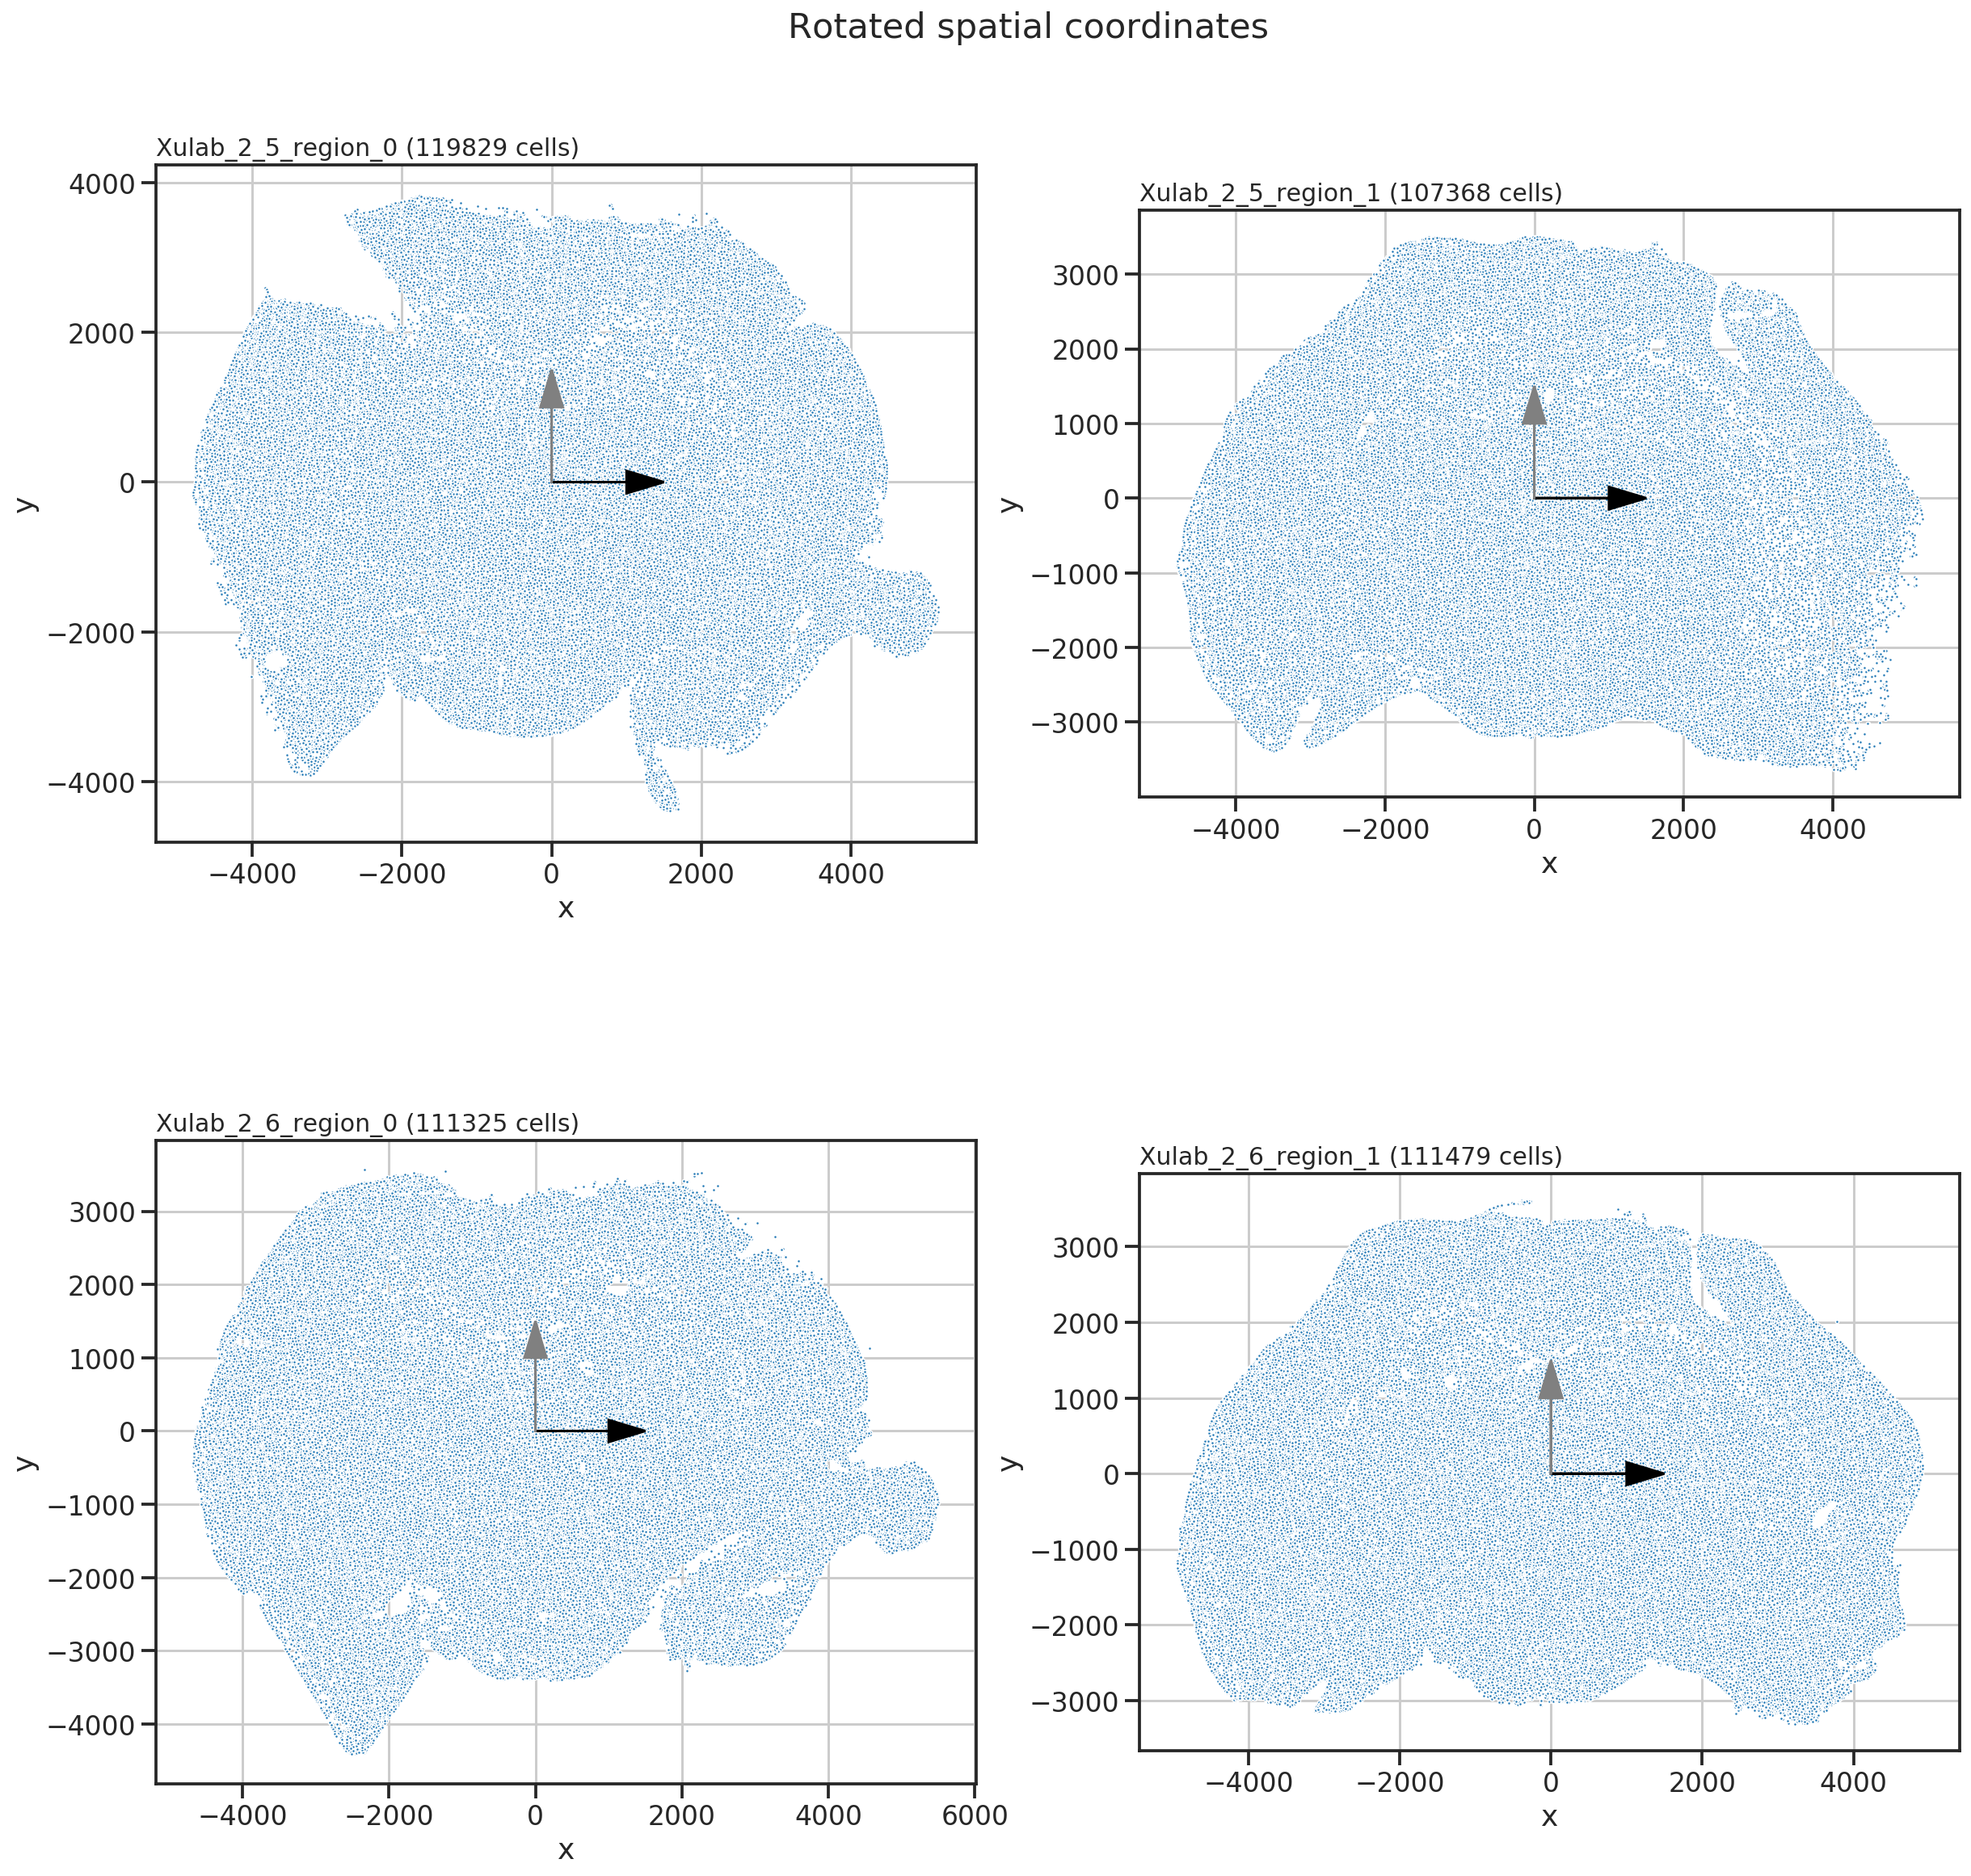

In [7]:
x, y, suptitle = 'x', 'y', 'Rotated spatial coordinates'
fig, axs = plt.subplots(2, 2, figsize=(20,20))
for i, (ax, sample) in enumerate(zip(axs.flat, alldata.keys())):
    toplot = alldata[sample]
    Vt = all_Vts[sample]
    Vt = Vt.dot(Vt.T)
    
    sns.scatterplot(x=x, y=y, data=toplot, 
                    s=4, markers=dict(marker_edge_color='none'),
                    rasterized=True,
                    ax=ax,
                   )
    ax.set_aspect('equal')
    xmean, ymean = toplot[x].mean(), toplot[y].mean()
    scale = 1000
    ax.arrow(xmean, ymean, scale*Vt[0,0], scale*Vt[0,1], 
             head_width=0.3*scale, head_length=0.5*scale, fc='k', ec='k')
    ax.arrow(xmean, ymean, scale*Vt[1,0], scale*Vt[1,1], 
             head_width=0.3*scale, head_length=0.5*scale, fc='gray', ec='gray')
    ax.set_title("{} ({} cells)".format(sample, len(toplot)), loc='left', fontsize=15)
fig.suptitle(suptitle, y=0.92)
plt.show()

# Save

In [9]:
# save alldata and rotation matrices as hdf5
import h5py
file = '../data/processed_merfish_ad_mouse_rotated_june2_2021.hdf5'
for sample in alldata.keys():
    with h5py.File(file, 'a') as f:
        f['Vt_'+sample] = all_Vts[sample]
    metas[sample].to_hdf(file, 'meta_'+sample, 'a')
    datas[sample].to_hdf(file, 'mat_'+sample, 'a')

In [10]:
with h5py.File(file, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['Vt_Xulab_2_5_region_0', 'Vt_Xulab_2_5_region_1', 'Vt_Xulab_2_6_region_0', 'Vt_Xulab_2_6_region_1', 'mat_Xulab_2_5_region_0', 'mat_Xulab_2_5_region_1', 'mat_Xulab_2_6_region_0', 'mat_Xulab_2_6_region_1', 'meta_Xulab_2_5_region_0', 'meta_Xulab_2_5_region_1', 'meta_Xulab_2_6_region_0', 'meta_Xulab_2_6_region_1']>


In [11]:
df = pd.read_hdf(file, 'meta_'+samples[0])
df

fov       volume      center_x  \
1180572846630481441529138875642910508    1445  1159.031678   1666.682977   
123728997372594040247704579971571050130  1445   261.252910   1702.052978   
141838298513381706222849139789989533595  1445   527.677988   1724.678979   
159299836930912089601219931918867429346  1445   538.329553   1746.872979   
178901354552570069198396499727421283408  1445   142.939178   1700.432978   
...                                       ...          ...           ...   
311194208382084618002138585201058095426  2957   232.352491  11597.608844   
330736968387024519566810550874960643942  2957   846.972656  11597.230844   
333062928452656089979261649679275837670  2957  1595.812342  11601.496844   
63059060266683180382621628812618934930   2957   363.233075  11614.618844   
81647014493483093753405864376072425262   2957  1416.382630  11601.280844   

                                             center_y         min_x  \
1180572846630481441529138875642910508    11909.208550   1658.680177   
123728997372594040247704579971571050130  11842.626548   1698.208178   
141838298513381706222849139789989533595  11874.702549   1715.920178   
159299836930912089601219931918867429346  11900.730549   1740.436179   
178901354552570069198396499727421283408  11850.888548   1697.884178   
...                                               ...           ...   
311194208382084618002138585201058095426  11254.553419  11593.332044   
330736968387024519566810550874960643942  11200.013417  11589.228044   
333062928452656089979261649679275837670  11251.097419  11593.440044   
63059060266683180382621628812618934930   11264.219419  11609.856044   
81647014493483093753405864376072425262   11169.341416  11592.576044   

                                                max_x         min_y  \
1180572846630481441529138875642910508     1674.685777  11897.965749   
123728997372594040247704579971571050130   1705.897778  11838.889748   
141838298513381706222849139789989533595   1733.437779  11867.401749   
159299836930912089601219931918867429346   1753.309779  11894.401749   
178901354552570069198396499727421283408   1702.981778  11848.393748   
...                                               ...           ...   
311194208382084618002138585201058095426  11601.885644  11252.382619   
330736968387024519566810550874960643942  11605.233644  11188.770617   
333062928452656089979261649679275837670  11609.553644  11238.126618   
63059060266683180382621628812618934930   11619.381645  11258.538619   
81647014493483093753405864376072425262   11609.985644  11157.450616   

                                                max_y  cell_cov  \
1180572846630481441529138875642910508    11920.451350      81.0   
123728997372594040247704579971571050130  11846.363348      41.0   
141838298513381706222849139789989533595  11882.003349      43.0   
159299836930912089601219931918867429346  11907.059350      60.0   
178901354552570069198396499727421283408  11853.383348       9.0   
...                                               ...       ...   
311194208382084618002138585201058095426  11256.724219      51.0   
330736968387024519566810550874960643942  11211.256218     131.0   
333062928452656089979261649679275837670  11264.068219     253.0   
63059060266683180382621628812618934930   11269.900219      72.0   
81647014493483093753405864376072425262   11181.232217     173.0   

                                         cell_cov_norm              sample  \
1180572846630481441529138875642910508        44.966196  Xulab_2_5_region_0   
123728997372594040247704579971571050130     100.976230  Xulab_2_5_region_0   
141838298513381706222849139789989533595      52.431938  Xulab_2_5_region_0   
159299836930912089601219931918867429346      71.713259  Xulab_2_5_region_0   
178901354552570069198396499727421283408      40.512371  Xulab_2_5_region_0   
...                                                ...                 ...   
311194208382084618002138585201058095426     141.227502  Xulab_2_5_region